In [1]:
import numpy as np
import pandas as pd
import zen
import matplotlib.pyplot as plt

In [2]:
coms = {}
key = 0
for line in open('com-youtube.top5000.cmty.txt','r'):
    nodes = np.array(line.split(),dtype=np.int64)
    coms[key] = [nodes,len(nodes)]
    key += 1

In [3]:
keys = coms.keys()
sizes = [s for i,s in coms.values()]

In [4]:
rankings = sorted(zip(sizes,keys),reverse=True)
top_comm1 = rankings[0][1]
top_comm2 = rankings[1][1]

comm1 = coms[top_comm1][0]
label1 = np.zeros(len(comm1))
comm2 = coms[top_comm2][0]
label2 = np.ones(len(comm2))

sampled_nodes = np.hstack([comm1,comm2])
labels = np.hstack([label1,label2])

sampledNodes = pd.DataFrame({'Nodes':sampled_nodes,'Community':labels})

In [5]:
temp=sampledNodes.groupby('Nodes').count()
s=temp.shape[0]
both = temp[temp['Community']==2].shape[0]/float(s)
print 'Percent of nodes in both communities: %.1f%%'%(100*both)

Percent of nodes in both communities: 25.9%


In [ ]:
%%time
G = zen.Graph()
l = 0
for line in open('com-youtube.ungraph.txt','rb'):
    l+=1
    if l>4:
        nodes = line.split()
        n1 = int(nodes[0])
        n2 = int(nodes[1])
        one_in = bool(sampledNodes[sampledNodes['Nodes']==n1].shape[0])
        two_in = bool(sampledNodes[sampledNodes['Nodes']==n2].shape[0])
        if one_in and two_in:
            G.add_edge(n1,n2)

In [6]:
evc = zen.algorithms.eigenvector_centrality_(G,weighted=True)
evc = evc - np.min(evc)
evc = evc / np.max(evc)

In [7]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.neighbors_(node):
                weight = G.weight_(G.edge_idx_(neighbor,node))
                Ax += np.multiply(centrality[neighbor],weight)

                #Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality


In [8]:
%%time
kc = katz(G,alpha=1e-6) #1e-6
kc = kc - np.min(kc)
kc = kc / np.max(kc)

CPU times: user 516 ms, sys: 32 ms, total: 548 ms
Wall time: 520 ms


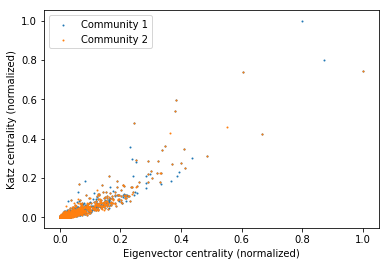

In [38]:
for c in [0,1]:
    nodes = sampledNodes[sampledNodes['Community']==c]['Nodes'].values
    idx = [G.node_idx(n) for n in nodes]
    plt.scatter(evc[idx],kc[idx],s=1,label='Community %d'%(c+1))
plt.xlabel('Eigenvector centrality (normalized)',fontsize=14)
plt.ylabel('Katz centrality (normalized)',fontsize=14)
#plt.xlim([0,0.1])
#plt.ylim([0,0.1])
plt.legend()
plt.savefig('figures/youtube.eps',bbox_inches='tight')

In [36]:
labels = np.zeros(G.num_nodes)
idx = [G.node_idx(n) for n in sampledNodes[sampledNodes['Community']==1]['Nodes'].values]
labels[idx] = 1

classes = {}
classes[0] = sampledNodes[sampledNodes['Community']==0]['Nodes'].values
classes[1] = sampledNodes[sampledNodes['Community']==1]['Nodes'].values

def modularity(G,classDict,classList):
    Q = zen.algorithms.modularity(G,classDict)
    # Maximum Modularity
    count=0.0
    for e in G.edges():
        n1 = G.node_idx(e[0])
        n2 = G.node_idx(e[1])
        if classList[n1] == classList[n2]:
            count += 1
    same = count / G.num_edges
    rand = same - Q
    qmax = 1 - rand
    return Q, qmax

q,qmax = modularity(G,classes,labels)
print q
print qmax
print q/qmax

0.0487836224548
0.447543098678
0.109003183378


In [40]:
G.num_nodes

3269